# **1.importing libraries and dataframes**

In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive
import pickle
from sklearn.model_selection import GridSearchCV, train_test_split

drive.mount('/content/drive')

train_sembedpath = '/content/drive/My Drive/train_embeds.npy'
train_embeddings = np.load(train_sembedpath)


Mounted at /content/drive


In [ ]:
# Print the shape of the loaded data to confirm
print("Loaded data shape:", train_embeddings.shape)

# converting embeddings numpy array(train_embeddings) into pandas dataframe.
column_num = train_embeddings.shape[1]
train_df = pd.DataFrame(train_embeddings, columns = ["Column_" + str(i) for i in range(1, column_num+1)])
print(train_df.shape)

train_df.head()

labels_df = pd.read_pickle('/content/drive/MyDrive/Colab Notebooks/Data/pkl files/labels_df.pkl')
print(labels_df.shape)


Loaded data shape: (142246, 1024)
(142246, 1024)
(142246, 1500)


# **2. Splitting data to get test and validation sets**

In [ ]:
# First, split the data into a training set and a temporary testing set
X_train, X_temp, y_train, y_temp = train_test_split(
    train_df, labels_df, test_size=0.2, random_state=42
)

# Next, split the temporary set into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)

# Display the dimensions of the sets to verify proper splitting
print(f"Training set dimensions: {X_train.shape}, {y_train.shape}")
print(f"Validation set dimensions: {X_val.shape}, {y_val.shape}")
print(f"Test set dimensions: {X_test.shape}, {y_test.shape}")

Training set dimensions: (113796, 1024), (113796, 1500)
Validation set dimensions: (14225, 1024), (14225, 1500)
Test set dimensions: (14225, 1024), (14225, 1500)


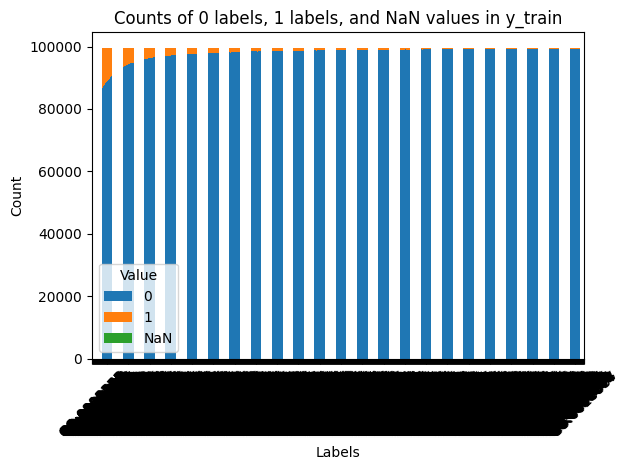

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Ensure y_train is a DataFrame
if not isinstance(y_train, pd.DataFrame):
    y_train = pd.DataFrame(y_train)

# Count the occurrences of 0s, 1s, and NaNs for each label
counts_0 = (y_train == 0).sum()
counts_1 = (y_train == 1).sum()
counts_nan = y_train.isna().sum()

# Combine counts into a DataFrame
counts = pd.DataFrame({
    '0': counts_0,
    '1': counts_1,
    'NaN': counts_nan
})

# Plotting the counts
counts.plot(kind='bar', stacked=True, rot=45)
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Counts of 0 labels, 1 labels, and NaN values in y_train')
plt.legend(title='Value')
plt.tight_layout()
plt.show()


# **Balancing Data with Smote**

In [ ]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, precision_recall_curve, auc
from scikeras.wrappers import KerasClassifier
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE

# Initialize SMOTE
smote = SMOTE(random_state=42)

# Function to apply SMOTE to individual label columns and ensure consistent X
def apply_smote_consistent(X_train, y_train):
    y_balanced_list = []
    for col in y_train.columns:
        y_col = y_train[col]
        X_res, y_res = smote.fit_resample(X_train, y_col)
        y_balanced_list.append(y_res)

        # Ensure X_train is set to the resampled X only once
        if len(y_balanced_list) == 1:
            X_balanced = X_res

    y_balanced = pd.concat(y_balanced_list, axis=1)
    return X_balanced, y_balanced

# Apply SMOTE to each label column individually
X_balanced, y_balanced = apply_smote_consistent(X_train, y_train)

# Save the balanced features and labels to pickle files
with open('/content/drive/My Drive/Colab Notebooks/Data/X_train_balanced.pkl', 'wb') as f:
    pickle.dump(X_balanced, f)

with open('/content/drive/My Drive/Colab Notebooks/Data/y_train_balanced.pkl', 'wb') as f:
    pickle.dump(y_balanced, f)

print("Balanced features and labels have been saved to X_train_balanced.pkl and y_train_balanced.pkl")

#**3.Importing balanced data for training**

In [ ]:
import pickle
from sklearn.model_selection import GridSearchCV, train_test_split
# Load the balanced features and labels from the pickle files
with open('/content/drive/MyDrive/Colab Notebooks/Data/pkl files/X_train_balanced.pkl', 'rb') as f:
    X_train = pickle.load(f)

with open('/content/drive/MyDrive/Colab Notebooks/Data/pkl files/y_train_balanced.pkl', 'rb') as f:
    y_train = pickle.load(f)

print("Balanced features and labels have been loaded from pickle files")

# Ensure the shapes match for model training
print(f'X_balanced shape: {X_train.shape}')
print(f'y_balanced shape: {y_train.shape}')

Balanced features and labels have been loaded from pickle files
X_balanced shape: (130362, 1024)
y_balanced shape: (198582, 1500)


# **4. Resampling balanced data**

In [ ]:
from sklearn.utils import resample
import pandas as pd

# Assuming X_train and y_train are the results of SMOTE and are numpy arrays
# Convert to DataFrame if they are not already
X_train = pd.DataFrame(X_train)
y_train = pd.DataFrame(y_train)

# Determine the smaller size
min_samples = min(len(X_train), len(y_train))

# Sample both X_train and y_train to the same size
X_train = resample(X_train, n_samples=min_samples, random_state=42)
y_train = resample(y_train, n_samples=min_samples, random_state=42)

# Verify shapes
print("X_train shape after resampling:", X_train.shape)
print("y_train shape after resampling:", y_train.shape)

X_train shape after resampling: (130362, 1024)
y_train shape after resampling: (130362, 1500)


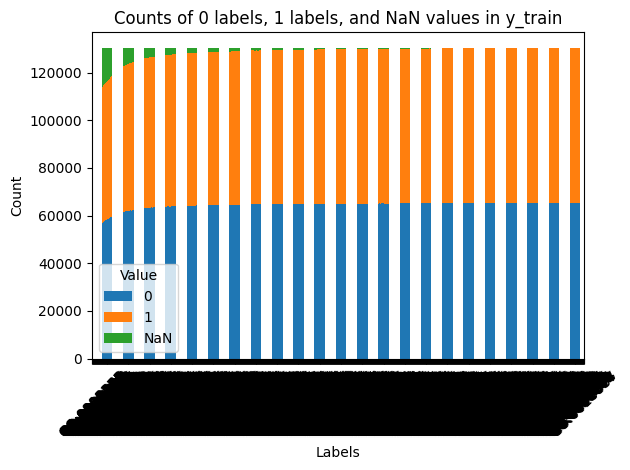

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Ensure y_train is a DataFrame
if not isinstance(y_train, pd.DataFrame):
    y_train = pd.DataFrame(y_train)

# Count the occurrences of 0s, 1s, and NaNs for each label
counts_0 = (y_train == 0).sum()
counts_1 = (y_train == 1).sum()
counts_nan = y_train.isna().sum()

# Combine counts into a DataFrame
counts = pd.DataFrame({
    '0': counts_0,
    '1': counts_1,
    'NaN': counts_nan
})

# Plotting the counts
counts.plot(kind='bar', stacked=True, rot=45)
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Counts of 0 labels, 1 labels, and NaN values in y_train')
plt.legend(title='Value')
plt.tight_layout()
plt.show()


# **5.1 showing data shapes and changing types**

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score, precision_recall_curve, auc, average_precision_score
from sklearn.preprocessing import StandardScaler

INPUT_SHAPE = [X_train.shape[1]]
BATCH_SIZE = 128
num_of_labels = 1500

# Convert DataFrames to NumPy arrays if necessary
X_train = X_train.to_numpy() if isinstance(X_train, pd.DataFrame) else X_train
y_train = y_train.to_numpy() if isinstance(y_train, pd.DataFrame) else y_train
X_val = X_val.to_numpy() if isinstance(X_val, pd.DataFrame) else X_val
y_val = y_val.to_numpy() if isinstance(y_val, pd.DataFrame) else y_val
X_test = X_test.to_numpy() if isinstance(X_test, pd.DataFrame) else X_test
y_test = y_test.to_numpy() if isinstance(y_test, pd.DataFrame) else y_test

# Ensure data shapes
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)

# Ensure data types
print("X_train dtype:", X_train.dtype)
print("y_train dtype:", y_train.dtype)
print("X_val dtype:", X_val.dtype)
print("y_val dtype:", y_val.dtype)

# Convert data types if necessary
X_train = X_train.astype(np.float64)
y_train = y_train.astype(np.float64)
X_val = X_val.astype(np.float64)
y_val = y_val.astype(np.float64)
X_test = X_test.astype(np.float64)
y_test = y_test.astype(np.float64)


X_train shape: (130362, 1024)
y_train shape: (130362, 1500)
X_val shape: (14225, 1024)
y_val shape: (14225, 1500)
X_train dtype: float64
y_train dtype: float64
X_val dtype: float64
y_val dtype: float64


# **Visualizing the distribution of NAN values within the data**

<ipython-input-11-f619763da001>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=nan_counts.index, y=nan_counts.values, palette='viridis')


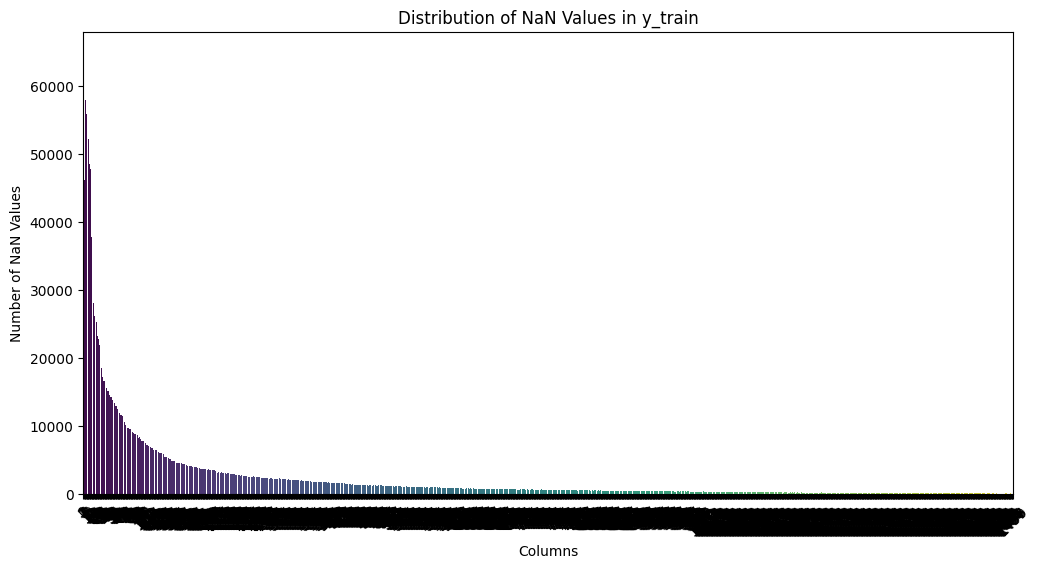

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


y_train = pd.DataFrame(y_train)
# Create a boolean DataFrame indicating NaN values
nan_df = y_train.isna()

# Sum up the NaN values for each column
nan_counts = nan_df.sum()

# Plotting
plt.figure(figsize=(12, 6))
sns.barplot(x=nan_counts.index, y=nan_counts.values, palette='viridis')
plt.title('Distribution of NaN Values in y_train')
plt.xlabel('Columns')
plt.ylabel('Number of NaN Values')
plt.xticks(rotation=45)
plt.show()


# **Removing NAN values with keeping classes balanced**

Initial shapes: X_train: (130362, 1024), y_train: (130362, 1500)
Aligned shapes: X_train_aligned: (130362, 1024), y_train_aligned: (130362, 1500)
Cleaned shapes: X_train_clean: (65654, 1024), y_train_clean: (65654, 1500)


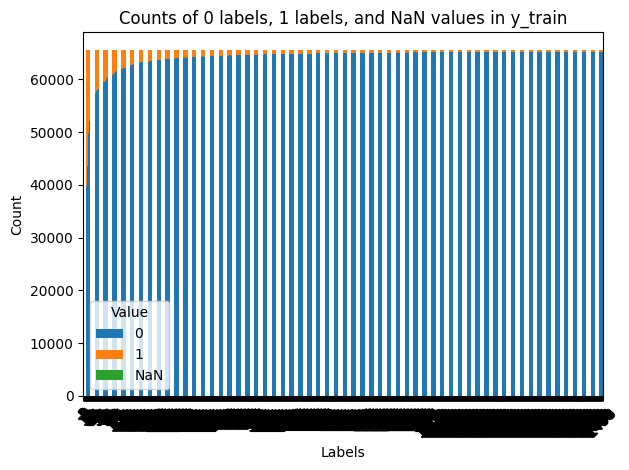

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Example y_train and X_train data (replace these with your actual data)
# y_train = pd.DataFrame({...})
# X_train = pd.DataFrame({...})

# Ensure y_train and X_train are DataFrames
if not isinstance(y_train, pd.DataFrame):
    y_train = pd.DataFrame(y_train)
if not isinstance(X_train, pd.DataFrame):
    X_train = pd.DataFrame(X_train)

# Print initial shapes
print(f"Initial shapes: X_train: {X_train.shape}, y_train: {y_train.shape}")


# Find common indices
common_indices = y_train.index.intersection(X_train.index)

# Align both DataFrames to the common indices
y_train_aligned = y_train.loc[common_indices]
X_train_aligned = X_train.loc[common_indices]

# Verify aligned shapes
print(f"Aligned shapes: X_train_aligned: {X_train_aligned.shape}, y_train_aligned: {y_train_aligned.shape}")

# Find rows with any NaN values in y_train
rows_with_nan = y_train_aligned.isna().any(axis=1)

# Remove these rows from both y_train and X_train
y_train_clean = y_train_aligned[~rows_with_nan]
X_train_clean = X_train_aligned.loc[y_train_clean.index]

# Verify the number of rows are equal
print(f"Cleaned shapes: X_train_clean: {X_train_clean.shape}, y_train_clean: {y_train_clean.shape}")

# Proceed with your analysis or model training using X_train_clean and y_train_clean

# Count the occurrences of 0s, 1s, and NaNs for each label in cleaned y_train
counts_0 = (y_train_clean == 0).sum()
counts_1 = (y_train_clean == 1).sum()
counts_nan = y_train_clean.isna().sum()  # This should be all zeros now

# Combine counts into a DataFrame
counts = pd.DataFrame({
    '0': counts_0,
    '1': counts_1,
    'NaN': counts_nan
})

# Plotting the counts
counts.plot(kind='bar', stacked=True, rot=45)
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Counts of 0 labels, 1 labels, and NaN values in y_train')
plt.legend(title='Value')
plt.tight_layout()
plt.show()


### **5.2 Constructing a DNN model**



In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.BatchNormalization(input_shape=INPUT_SHAPE),
    tf.keras.layers.Dense(units=1024, activation=None, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(alpha=0.1),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Dense(units=512, activation=None, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(alpha=0.1),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Dense(units=512, activation=None, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(alpha=0.1),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Dense(units=num_of_labels, activation='sigmoid')
])

# Compile model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4, clipnorm=1.0),
    loss='binary_crossentropy',
    metrics=['binary_accuracy', tf.keras.metrics.AUC()],
)

### **5.3 Training the model with verbose output**

In [ ]:
# Train the model with verbose output
history = model.fit(
    X_train, y_train,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(X_val, y_val),
    verbose=1  # Enable verbose output to get more details
)

**5.4 Evaluating the model and calculating scores**

In [ ]:
# Evaluate the Dense model
dense_scores = model.evaluate(X_test, y_test)

# Calculate F1 score and AUPR for the Dense model
dense_predictions = model.predict(X_test)

def f_max_score(y_true, y_pred, beta):
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)

    f_max = (1 + beta**2) * (precision * recall) / ((beta**2 * precision) + recall)

    return f_max

beta = 0.5  # Set the beta parameter for F-max score calculation
densen_f1= f_max_score(y_test, np.round(dense_predictions), beta)


dense_aupr = average_precision_score(y_test, dense_predictions)

890/890 [==============================] - 12s 13ms/step


### **6. Plotting results and training history**

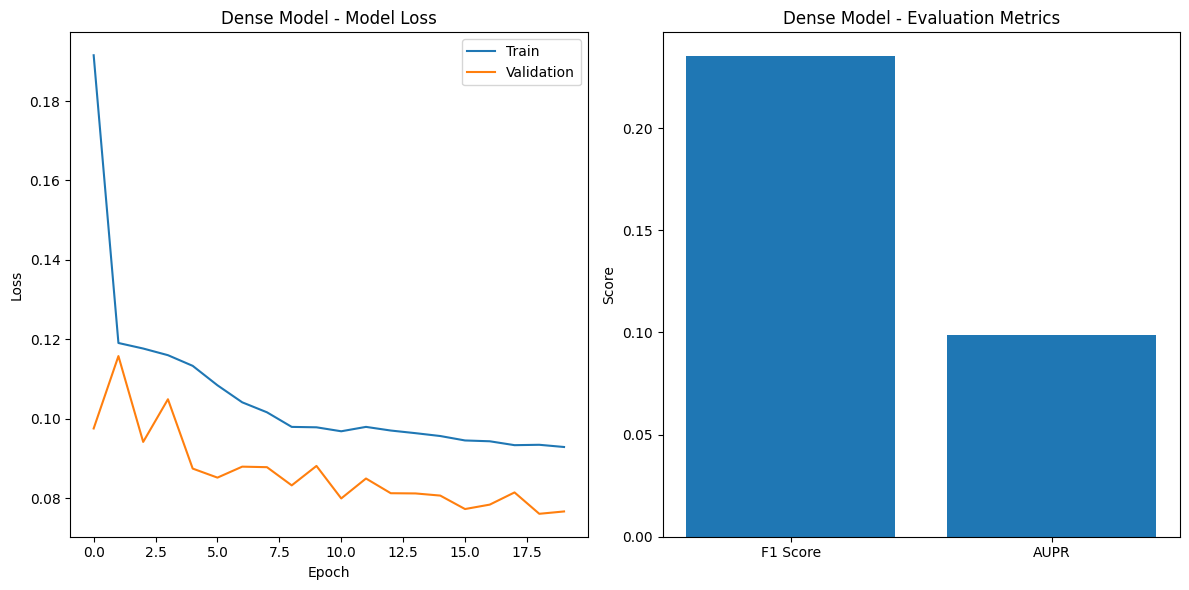

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Dense on balanced data Evaluation:
Loss: 0.07772602885961533
Binary Accuracy: 0.9803950190544128
AUPR: 0.09886193292211376
F1 Score: 0.23508448248591807


In [ ]:
# Define the plot_results function
def plot_results(history, scores, f1, aupr, model_name):
    plt.figure(figsize=(12, 6))

    # Plot training & validation loss values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'{model_name} - Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper right')

    # Plot F1 score and AUPR
    plt.subplot(1, 2, 2)
    plt.bar(['F1 Score', 'AUPR'], [f1, aupr])
    plt.title(f'{model_name} - Evaluation Metrics')
    plt.ylabel('Score')

    plt.tight_layout()
    plt.show()
# Plot results for the Dense model
plot_results(history, dense_scores, dense_f1, dense_aupr, 'Dense Model')

# Save the Dense model
model.save('/content/drive/My Drive/Colab Notebooks/Data/DNN_opt_model.h5')

# Print and save evaluation metrics
print("Dense on balanced data Evaluation:")
print("Loss:", dense_scores[0])
print("Binary Accuracy:", dense_scores[1])
print("AUPR:", dense_aupr)
print("F1 Score:", dense_f1)

# Save evaluation metrics to a text file
with open('dense_model_metrics.txt', 'w') as f:
    f.write("DNN Model Evaluation:\n")
    f.write(f"Loss: {dense_scores[0]}\n")
    f.write(f"Binary Accuracy: {dense_scores[1]}\n")
    f.write(f"AUPR: {dense_aupr}\n")
    f.write(f"F1 Score: {dense_f1}\n")


# **Confusion matrix**

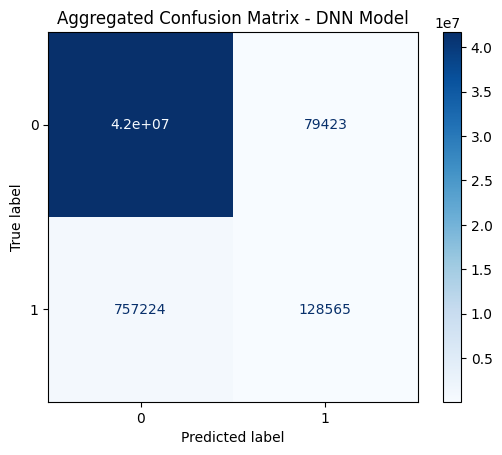

In [ ]:
if isinstance(y_test, pd.DataFrame):
    y_test = y_test.to_numpy()
if isinstance(dense_predictions, pd.DataFrame):
    dense_predictions = dense_predictions.to_numpy()

# Round the predictions to get binary outcomes
rounded_predictions = np.round(dense_predictions)

# Reshape the arrays into a single dimension
y_test_flat = y_test.ravel()
rounded_predictions_flat = rounded_predictions.ravel()

# Generate the confusion matrix
cm = confusion_matrix(y_test_flat, rounded_predictions_flat)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Aggregated Confusion Matrix - DNN Model')
plt.show()

# **Model Summary and architecture**

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (Batch  (None, 1024)              4096      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 1024)              1049600   
                                                                 
 batch_normalization_1 (Bat  (None, 1024)              4096      
 chNormalization)                                                
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 1024)              0         
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               5